# Architecture CNN
Train a CNN model then test it on the whole picture and save the result image.

In [1]:
import matplotlib.pyplot as matPlt
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers

import math

from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix

import rasterio
from rasterio import plot as rastPlt
from rasterio.plot import reshape_as_raster
from rasterio.merge import merge as rasterMerge
from rasterio.mask import mask as rasterMask

from shapely.geometry import Polygon, box
import junodch_utils_read_img as utils

# Data preparation
### Fetch data from files
Extract the area covered by the image by the satellite (sentinel-2) and extracte all pixels coordinates from the night image (VIIRS).
dataCoords will be use to fetch the individual training and testing tile for the machine learning model. dataRadiance contains the light intensity of each tile.
dataCoords and dataRadiance have the same size and each entry matches the same tile.
the only variable that sould be changed is folderName after fetching the data from 1-fetch-data and merging them in 2-image-merge.

In [2]:
folderName = "img/Yemen/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print(len(dataCoords))

140208


#### Validation
Extract the data from GHSL. This is not a perfect metric the validation but will be use to filter some of the data used before training.

In [3]:
with rasterio.open(pathValidation) as f:
  sampleTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True) # arbitrary coordinate for a sample
print('Validation shape:',sampleTile.shape) # shape sample

print('Process validation...')
# If any of the pixels have a settlement then true else false
getValid = lambda data : [ int(250/255 < img.max()) for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=sampleTile.shape[1])

Validation shape: (4, 9, 9)
Process validation...


#### Fetch images
Fetch the images to use for the training of the model.
As muche as possible we want to be sure that the lightCoords matches tiles containing human settlement pictures and darkCoords matches tiles that are not human settlement.
This is why the resultValid is used to mask some of the data.

In [4]:
# Fetch images
lightMask = (dataRadiance>0) & (resultValid == 1)
lightCoords = dataCoords[lightMask]
darkMask = (dataRadiance==0) & (resultValid == 0)

idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[darkMask], len(lightCoords), replace=False)
darkCoords = dataCoords[idxDarkData]

trainCoords = np.concatenate((lightCoords, darkCoords))

with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, trainCoords, res=64)
print(trainData.shape)

print('Light Tile:',len(lightCoords))
print('dark Tile:',len(darkCoords))
print('Total train',trainData.shape)

train = trainData
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[idxDarkData]))

(3080, 64, 64, 3)
Light Tile: 1540
dark Tile: 1540
Total train (3080, 64, 64, 3)


## CNN
By default, an unchanged adam optimizer with mse loss function and a relu activation function.  
The default layers have : [32, 16, 8] filters
The original picture is supposed to be 64x64 pixels and it's reduce into a 8x8 pixels before being flatten.  
The final result is one value between 0 and 1.  
0 means no human settlement so no light. 1 means light so human settlement.

In [5]:
# Input encoder
input_shape = keras.Input(shape=trainData.shape[1:])

#optimizer = 'adam'
optimizer = keras.optimizers.Adam(
  learning_rate=0.0003,
  beta_1=0.9,
  beta_2=0.999,
)
lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = 'relu'

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)

cnn = layers.Conv2D(12,(3,3), 2, padding='same', activation=activationFunction)(input_shape)
cnn = layers.Conv2D(12,(3,3), 2, padding='same', activation=activationFunction)(cnn)
cnn = layers.Conv2D(12,(3,3), 2, padding='same', activation=activationFunction)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(1, activation='sigmoid')(cnn)

modelCNN = keras.Model(input_shape, cnn)
modelCNN.compile(optimizer=optimizer, loss=lossFunction)

result = modelCNN.fit(
  x=train[::2],
  y=validation[::2],
  epochs=50,
  batch_size=4,
  verbose=0,
  validation_data=(train[1::2], validation[1::2]),
  callbacks=[
    TqdmCallback(verbose=1), # Concise display progression
    earlyStop,
  ],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 12)        336       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        1308      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 12)          1308      
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 3,721
Trainable params: 3,721
Non-trainable par

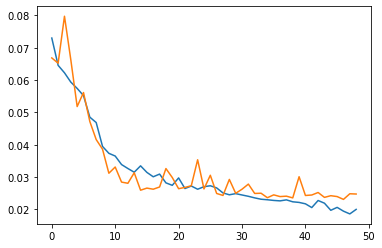

In [6]:
matPlt.plot(result.history['loss'][1:], label='Training')
matPlt.plot(result.history['val_loss'][1:], label='test')
modelCNN.summary()

## Analyse model
Calculate all tiles prediction by the model.

In [7]:
print('Process score...')
getScore = lambda data : modelCNN.predict(data, verbose=0).flatten()
result = utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=100, res=64)

Process score...


### Get the confusion matrix.  
**Adjust "threshold", this is an arbitrary value to get the best f-score !**

The matrix is calculated by comparing the prediction against the GHSL data contained in resultValid.
There are no garantees that a false negative or positive are truly false. This will require to be check manually to the file 4-validation-map.ipynb

In [18]:
threshold = 0.4

print('Process confustion matrix...')
print(len(result))
resultTest = (np.asarray(result) > threshold).astype(int)
confusionMatrix = confusion_matrix(resultValid, resultTest)
print(confusionMatrix)
tp = confusionMatrix[1][1]
fp = confusionMatrix[0][1]
fn = confusionMatrix[1][0]
print('f-score:',round(tp / (tp + (fp + fn)/2) * 100, 2),"%")
print('tp / fp:',round(tp / (tp + fp) * 100,2),"%")

Process confustion matrix...
140208
[[116708   1142]
 [ 20302   2056]]
f-score: 16.09 %
tp / fp: 64.29 %


### Display the resulting map
On the left is the original image  
On the right is the GHSL data  
In the center is the resulting image of the model   
  
Green means tp: This is a human settlement by the model prediction and by GHSL  
Blue means tn: This is not a human settlement by the model prediction and by GHSL  
Red means fp: The prediction says this is a human settlement but GHSL does not.  
Purple means fn: The prediction did not said that was a human settlement but GHSL did.  
  
In otherword : Green and blue are good. but the rest must be double check in the file 4-validation-model.

In [19]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest, resultValid)


fig, axs = matPlt.subplots(1,3, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

with rasterio.open(pathValidation) as p: rastPlt.show(p, ax=axs[2])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])

'''
fig, axs = matPlt.subplots(1,1, dpi=240)
utils.displayTiles([resultImg], [resultMeta], axs)
'''

# Sauvegarde de l'image et du model

In [29]:
modelCNN.save('model/cnn_64px_12_12_12_v3')

INFO:tensorflow:Assets written to: model/cnn_64px_32_16_8_v2\assets


INFO:tensorflow:Assets written to: model/cnn_64px_32_16_8_v2\assets


In [30]:
img = np.copy(resultImg)
img = img[0:3,:,:]
img = img.transpose([1, 2, 0])
with rasterio.open(pathNight) as f:
  profile = f.profile
img = reshape_as_raster(img)
profile.update(count=3)
print(profile)
print(img.shape)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 512, 'height': 512, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(611.4962262814097, 0.0, 3443640.9983037603,
       0.0, -611.4962262814108, 783020.9177533448), 'tiled': False, 'interleave': 'pixel'}
(3, 512, 512)


In [31]:
with rasterio.open(folderName + 'cnn_64px_12_12_12.tif', 'w', **profile) as f:
  f.write(img)
